In [1]:
from dataloader import create_dataset, erase_background, random_crop
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pybalu.feature_selection import sfs, clean
from pybalu.feature_transformation import pca, normalize
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from scipy import stats
import skimage.measure
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import cv2
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

In [12]:
# Path de los datos a clasificar
root = './FaceMask166/'
splits = ['A', 'B', 'C', 'D']
full_face = False
path_load = './features/features_split_{}_ff_{}_{}_{}.pkl'
methods = ['lbp','HOG']

def get_predictions(split):

    # Se obtienen las características de las imágenes a clasificar, así como los labels de cada una de estas.
    X_train, gt_train, X_val, gt_val, X_test, gt_test, train_imgs_path,\
    val_imgs_path, test_imgs_path,  img_train, img_val, img_test = create_dataset(root=root,
                                                                                  methods=methods,
                                                                                  split=split,
                                                                                  full_face=full_face,
                                                                                  path_load=path_load,
                                                                                  crop_enable = False,
                                                                                  n_crops = 20,
                                                                                  ratio = 0.5)



    # Se normalizan las features obtenidas, buscando tener media = 0 y std = 1
    scaler_nmf = StandardScaler()
    scaler_nmf.fit(X_train)
    X_train = scaler_nmf.transform(X_train)
    X_val = scaler_nmf.transform(X_val)
    X_test = scaler_nmf.transform(X_test)

    # Se seleccionan las features buscando maximizar el accuracy del modelo. 
    clf = ExtraTreesClassifier(n_estimators=300, random_state = 7).fit(X_train,gt_train)
    model = SelectFromModel(clf, prefit=True)
    X_train = model.transform(X_train)
    X_val = model.transform(X_val)
    X_test = model.transform(X_test)

    # Se procesa a clasificar usando un Support Vector Machine Classifier with linear Kernel. 
    svm = LinearSVC(random_state=0, tol=1e-05).fit(X_train, gt_train)

    y_pred_train_svm = svm.predict(X_train)
    acc_train_svm = np.sum(y_pred_train_svm == gt_train)/(gt_train.shape[0])*100

    y_pred_val_svm = svm.predict(X_val)
    acc_val_svm = np.sum(y_pred_val_svm == gt_val)/(gt_val.shape[0])*100

    y_pred_test_svm = svm.predict(X_test)
    acc_test_svm = np.sum(y_pred_test_svm == gt_test)/(gt_test.shape[0])*100

    print("acc_train split {}: {}".format(split, str(acc_train_svm)))
    print("acc_val split {}: {}".format(split, str(acc_val_svm)))
    print("acc_test split {}: {}".format(split, str(acc_test_svm)))
    
    return {
        'y_pred_train_svm': y_pred_train_svm,
        'y_pred_val_svm': y_pred_val_svm,
        'y_pred_test_svm': y_pred_test_svm,
        'gt_train': gt_train,
        'gt_val': gt_val,
        'gt_test': gt_test,
        'img_train': img_train,
        'img_val': img_val,
        'img_test': img_test,
    }


def show_bad_examples(dict_, max_rows = None):    
    img_train = dict_['img_train']
    gt_train = dict_['gt_train']
    sorted_order = gt_train.argsort()
    img_train = img_train[sorted_order]
    gt_train = gt_train[sorted_order]
    
    img_test = dict_['img_test']    
    gt_test = dict_['gt_test']
    pred_test = dict_['y_pred_test_svm']
    
    ncols = 4
    nrows = (gt_test != pred_test).sum()
    if max_rows:
        nrows = min(nrows, max_rows)
    idx = 0
    
    print('nrows = ', nrows)
    
    plt.figure(1, (4 * 3, nrows * 3))
    
    for i in range(gt_test.shape[0]):
        
        if gt_test[i] != pred_test[i]:
            
            ax = plt.subplot(nrows, ncols, 1 + ncols * idx)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_title('query: idx = %d, label = %d' % (i, gt_test[i]))
            ax.imshow(img_test[i][:,:,::-1], interpolation="nearest")

            for k in range(3):
                ax = plt.subplot(nrows, ncols, 1 + ncols * idx + 1 + k)
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_title('idx = %d, label = %d' % (pred_test[i] * 3 + k, pred_test[i]))
                ax.imshow(img_train[pred_test[i] * 3 + k][:,:,::-1], interpolation="nearest")
    
            idx += 1
            if idx >= nrows:
                break

    plt.show()

In [4]:
preds_split_A = get_predictions('A')

Features de Train
feature file loaded
Features de Val
feature file loaded
Features de Test
feature file loaded
acc_train split A: 100.0
acc_val split A: 93.75
acc_test split A: 90.625


In [6]:
preds_split_B = get_predictions('B')

  0%|          | 0/120 [00:00<?, ?it/s]

Features de Train


  0%|          | 0/40 [00:00<?, ?it/s]

Features de Val


  0%|          | 0/80 [00:00<?, ?it/s]

Features de Test


100%|██████████| 80/80 [00:24<00:00,  3.26it/s]


acc_train split B: 100.0
acc_val split B: 82.5
acc_test split B: 88.75


In [8]:
preds_split_C = get_predictions('C')

  0%|          | 0/300 [00:00<?, ?it/s]

Features de Train


  0%|          | 0/100 [00:00<?, ?it/s]

Features de Val


  0%|          | 0/200 [00:00<?, ?it/s]

Features de Test


100%|██████████| 200/200 [01:02<00:00,  3.22it/s]


acc_train split C: 100.0
acc_val split C: 84.0
acc_test split C: 85.5


In [9]:
preds_split_D = get_predictions('D')

  0%|          | 0/498 [00:00<?, ?it/s]

Features de Train


  0%|          | 0/166 [00:00<?, ?it/s]

Features de Val


  0%|          | 0/332 [00:00<?, ?it/s]

Features de Test


100%|██████████| 332/332 [01:40<00:00,  3.29it/s]


acc_train split D: 100.0
acc_val split D: 76.50602409638554
acc_test split D: 80.42168674698796


nrows =  3


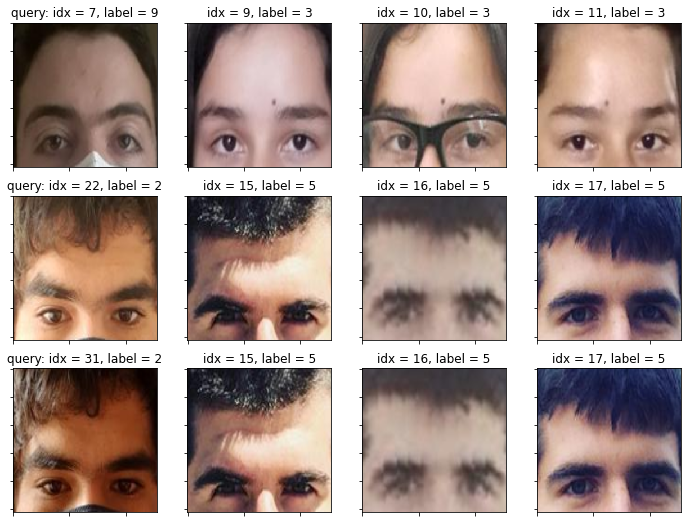

In [15]:
show_bad_examples(preds_split_A, 3)

nrows =  3


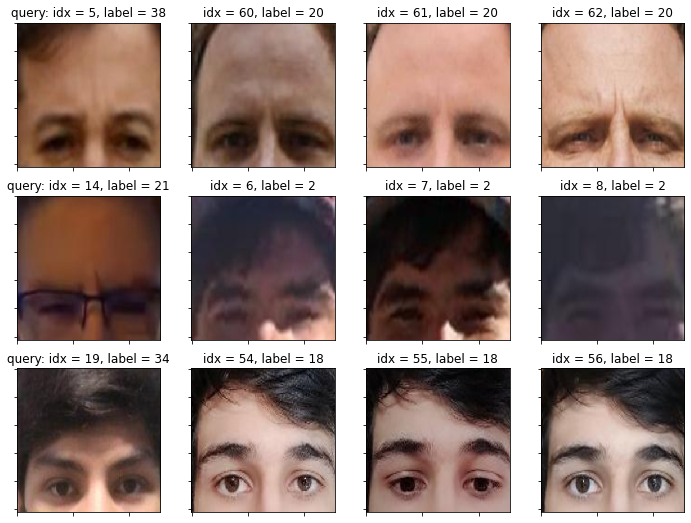

In [16]:
show_bad_examples(preds_split_B, 3)

nrows =  4


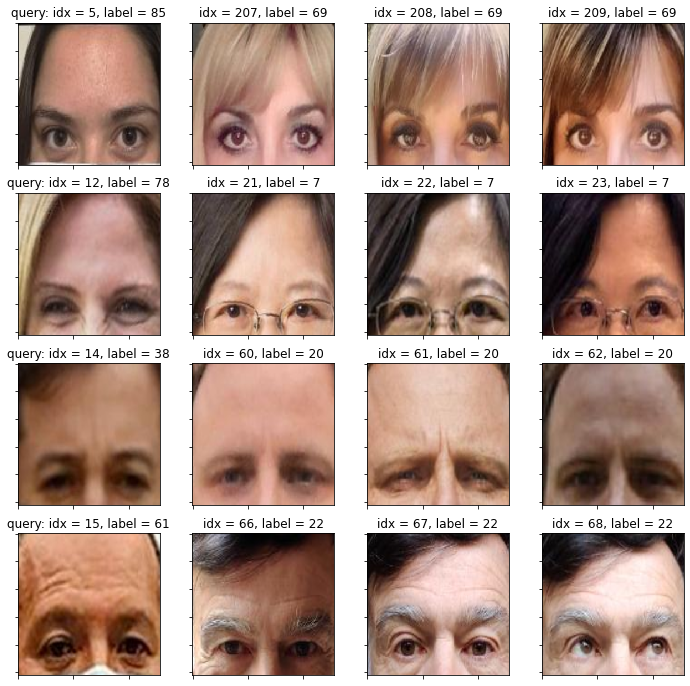

In [17]:
show_bad_examples(preds_split_C, 4)

nrows =  4


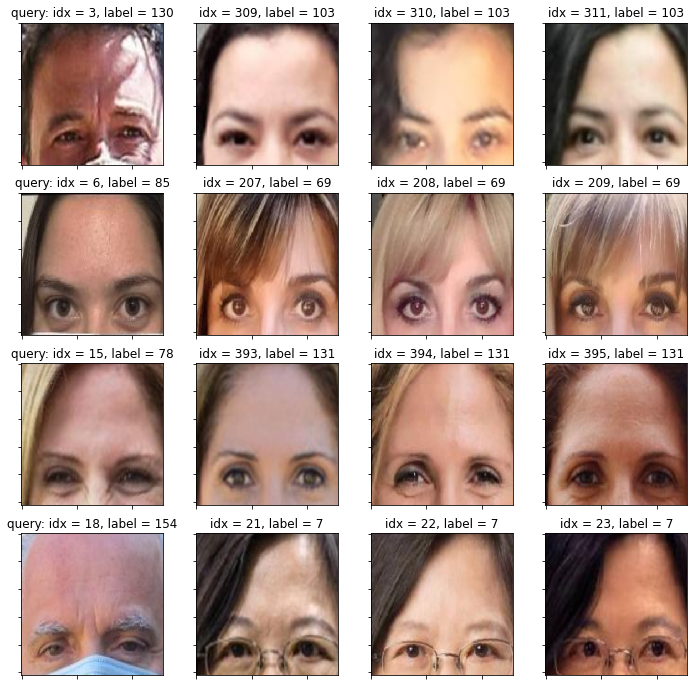

In [18]:
show_bad_examples(preds_split_D, 4)